## Partie 4 : Intégration Numérique

Dans cette section, nous utilisons des méthodes d'intégration numérique pour analyser divers indicateurs épidémiologiques.


In [50]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt


# Importation des modules internes du projet
from src.analysis import estimer_parametres_rab
from src.analysis.equations_differentielles.simulateur_sird import SimulateurSIRD
from src.analysis.integration.methodes import Integration
from src.analysis.derivation.methodes import Derivation
from src.data import DataPipeline

In [51]:
# Chargement des données pour le pays France
pipeline = DataPipeline(country="France")
df = pipeline.run(smoothing=True)

population = pipeline.population
parametres = estimer_parametres_rab(df)

### Question a) Estimation du nombre total d'infections

**Objectif** : Calculer le nombre total de personnes infectées entre $t_0$ et $t_f$ via l'intégrale :
$I_{total} = \int_{t_0}^{t_f} \frac{dI}{dt} dt = \int_{t_0}^{t_f} [rS(t)I(t) - (a + b)I(t)] dt$</br>
**Méthode** : Utilisation de la méthode de Simpson sur le terme $rS(t)I(t)P$ (où $P$ = population totale).


In [52]:
# Calcul du flux d'infections
df["flux_infections"] = parametres["r"] * df["S"] * df["I"] * population

# Intégration numérique
I_total = Integration(df=df, col="flux_infections", h=1.0).simpson()

#### Résultats


In [53]:
print(f"Nombre total d'infections estimé : {I_total:.2f} personnes")

Nombre total d'infections estimé : 37243480.90 personnes


### Question b) Calcul du nombre cumulé de cas infectés et de guérisons

**Objectif** : Calculer les quantités cumulées via :</br>
$I_{cum}(t) = \int_0^t rS(\tau)I(\tau)d\tau,\quad R_{cum}(t) = \int_0^t aI(\tau)d\tau$</br>


In [ ]:
# Calcul de la population totale à partir des données initiales (valeurs absolues)
P = (
    df[["S_abs", "I_abs", "R_abs", "D_abs"]].iloc[0].sum()
)  # Population totale au jour initial


a = parametres["a"]  # Taux de guérison
b = parametres["b"]  # Taux de mortalité
r = parametres["r"]  # Taux de contagion

# Calcul de la population totale à partir des données initiales (valeurs absolues)
# Initialisation des colonnes pour stocker les intégrales cumulatives
df["I_cumulatif"] = 0.0  # Infections cumulées
df["R_cumulatif"] = 0.0  # Guérisons cumulées
df["new_infecs"] = r * df["S"] * df["I"] * P
df["new_recov"] = a * df["I"] * P
# Boucle sur chaque jour pour calculer les intégrales cumulatives
for i in range(len(df)):
    # Extraction des données du jour 0 jusqu'au jour courant i
    sub_df = df.iloc[: i + 1]  # Sous-DataFrame pour l'intégration

    # Calcul des nouvelles infections cumulées via la méthode de Simpson
    integ_infecs = Integration(
        sub_df, "new_infecs", h=1
    )  # Instanciation de l'intégrateur
    df.at[i, "I_cumulatif"] = (
        integ_infecs.simpson() * P
    )  # Application de Simpson + mise à l'échelle

    # Calcul des guérisons cumulées via la méthode de Simpson
    integ_recov = Integration(
        sub_df, "new_recov", h=1
    )  # Instanciation de l'intégrateur
    df.at[i, "R_cumulatif"] = (
        integ_recov.simpson() * P
    )  # Application de Simpson + mise à l'échelle

#### Résultats



Aperçu du DataFrame avec indicateurs cumulés :
      Jour   I_cumulatif   R_cumulatif
1334  1335  2.525592e+15  2.633145e+15
1335  1336  2.525155e+15  2.632596e+15
1336  1337  2.525592e+15  2.633145e+15
1337  1338  2.525155e+15  2.632596e+15
1338  1339  2.525592e+15  2.633145e+15


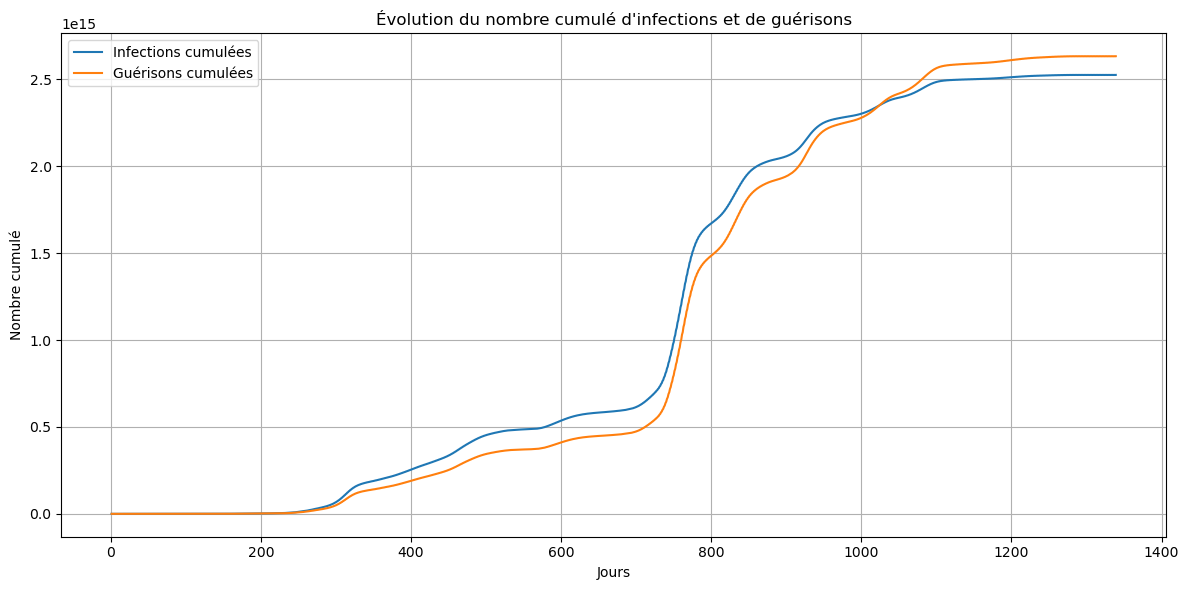

In [55]:
# Affichage des résultats
print("\nAperçu du DataFrame avec indicateurs cumulés :")
print(
    df[["Jour", "I_cumulatif", "R_cumulatif"]].tail(5)
)  # Dernières lignes pour validation

# Visualisation de l'évolution temporelle
plt.figure(figsize=(12, 6))
plt.plot(df["Jour"], df["I_cumulatif"], label="Infections cumulées")
plt.plot(df["Jour"], df["R_cumulatif"], label="Guérisons cumulées")

plt.title("Évolution du nombre cumulé d'infections et de guérisons")
plt.xlabel("Jours")
plt.ylabel("Nombre cumulé")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Question c) Détermination de la durée totale de l’épidémie

**Objectif** : Déterminer le temps $T$ où $I(T) \approx 0$ via : </br>
$\int_{t_0}^T \frac{dI}{dt}dt \approx 0$ </br>


In [ ]:
# Création de l'objet Derivation pour calculer la dérivée de I
derv = Derivation(df, "I", h=1)

# Calcul de la dérivée première par la méthode des 5 points
df["derivé"] = derv.premier_derivation_5point()

# Récupération des valeurs de la dérivée dans un tableau numpy
array = df["derivé"].values

epsilon = 1e-12

for i in range(len(array)):
    if all(v < epsilon for v in array[i:]):
        index = i
        break
    index = -1

#### Résultats


In [57]:
# Affichage de l'indice où l'épidémie est considérée comme terminée
print(f"le jour est {index}")

le jour est 1289


### Question d) Impact des mesures de contrôle

**Objectif** : Quantifier la réduction d'infections grâce aux mesures sanitaires via :</br>
$\text{Impact} = \int_0^T I_{\text{sans}}(t)dt - \int_0^T I_{\text{avec}}(t)dt$


In [58]:
# Définition de la date de confinement (2e confinement en France)
# Le confinement a officiellement commencé le 30 octobre 2020.
# Toutefois, l'effet sur la dynamique épidémique est différé de plusieurs jours.
# Pour éviter de capturer des dynamiques pré-confinement, on décale la période de prise en compte à +10 jours.
date_confinement = "2020-11-09"

# Segmenter les données en deux périodes
df_sans_mesures = df[df["date"] < date_confinement].copy()
df_avec_mesures = df[df["date"] >= date_confinement].copy()

# Estimer les paramètres pour chaque période
params_sans = estimer_parametres_rab(df_sans_mesures)
params_avec = estimer_parametres_rab(df_avec_mesures)

# Affichage des paramètres pour interprétation
print("Paramètres sans mesures:", params_sans)
print("Paramètres avec mesures:", params_avec)

Paramètres sans mesures: {'r': 0.09537560983886398, 'a': 0.05045253688668398, 'b': 0.0019648018142611125}
Paramètres avec mesures: {'r': 0.09658567963947046, 'a': 0.07321267693491842, 'b': 0.00031673418280537624}


In [ ]:
# Simulation numérique de la propagation de l'épidémie à l'aide du modèle SIRD
# pour chaque ensemble de paramètres (sans et avec mesures)

# Simulation
t_max = 365
simulateur_sans = SimulateurSIRD(params_sans)
result_sans = simulateur_sans.resoudre(
    df=df_sans_mesures, t_max=t_max, dt=1.0, methode="rk4"
)

simulateur_avec = SimulateurSIRD(params_avec)
result_avec = simulateur_avec.resoudre(
    df=df_avec_mesures, t_max=t_max, dt=1.0, methode="rk4"
)

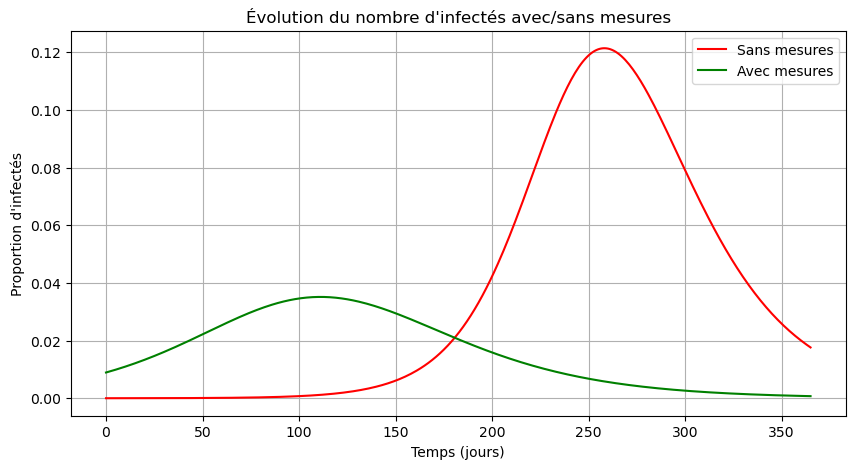

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(result_sans["temps"], result_sans["I"], label="Sans mesures", color="red")
plt.plot(result_avec["temps"], result_avec["I"], label="Avec mesures", color="green")
plt.xlabel("Temps (jours)")
plt.ylabel("Proportion d'infectés")
plt.title("Évolution du nombre d'infectés avec/sans mesures")
plt.legend()
plt.grid(True)
plt.show()

#### Résultats


In [61]:
# Calcul de l'intégrale de la courbe des infectés pour chaque simulation
# Cela permet d'estimer le "nombre de personnes × jours" infectées

# Intégration sur la période sans mesures
intg_sans = Integration(df=result_sans, col="I", h=1.0)
integral_sans = intg_sans.simpson() * pipeline.population

# Intégration sur la période avec mesures
intg_avec = Integration(df=result_avec, col="I", h=1.0)
integral_avec = intg_avec.simpson() * pipeline.population

# Impact des mesures
impact = integral_sans - integral_avec
print(f"Réduction des cas grâce aux mesures : {impact:.2f} (personnes × jours)")

Réduction des cas grâce aux mesures : 513131682.86 (personnes × jours)


### Question e) Estimation du nombre de doses de vaccin nécessaires pour atteindre l'immunité collective

**Objectif** : Calculer le nombre de doses nécessaires pour l'immunité collective via : </br>
$N_{vacc} = \int_0^T V(t)dt \quad \text{où } V(t) = \text{taux de vaccination}$ </br>


In [62]:
integrator = Integration(df, "V_abs", h=1)
# Option 1 : Utiliser la colonne V_abs (nombre absolu de vaccinations quotidiennes)
total_vaccinations_abs = integrator.simpson()

# Option 2 : Estimer à partir de la population totale et du seuil d'immunité
# Seuil d'immunité collective (ex. 70% de la population)
seuil_immunite = 0.70

# Population totale (à partir des données initiales)
population_totale = df[["S_abs", "I_abs", "R_abs", "D_abs"]].iloc[0].sum()

# Nombre cible de personnes à vacciner
cible_vaccination = seuil_immunite * population_totale


Aperçu des données de vaccination :


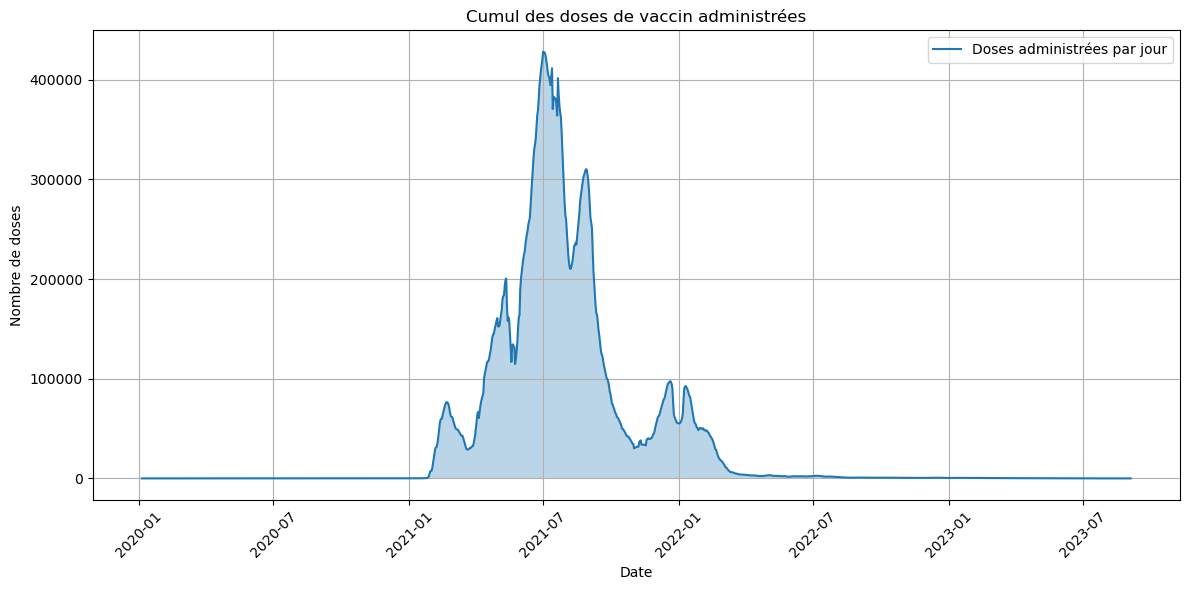

In [ ]:
print("\nAperçu des données de vaccination :")

plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["V_abs"], label="Doses administrées par jour")
plt.fill_between(df["date"], df["V_abs"], alpha=0.3)

plt.title("Cumul des doses de vaccin administrées")
plt.xlabel("Date")
plt.ylabel("Nombre de doses")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Résultats


In [64]:
print(
    f"\nNombre total de doses administrées (intégral de V_abs) : {total_vaccinations_abs:.0f}"
)

if total_vaccinations_abs >= cible_vaccination:
    print(f" L'immunité collective semble atteinte selon les données.")
else:
    manquant = cible_vaccination - total_vaccinations_abs
    print(f" L'immunité collective n'est pas encore atteinte.")
    print(
        f"Il manque environ {manquant:.0f} doses pour atteindre {seuil_immunite * 100}% de la population."
    )


Nombre total de doses administrées (intégral de V_abs) : 53218766
 L'immunité collective semble atteinte selon les données.
